The dataset used in this notebook is Tesla stock history from 2014 to 2017. You can find the .csv file in the project folder.

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Step 0. Loading dataset

In [3]:
tesla_stocks = pd.read_csv('data/tesla_stocks.csv')

In [4]:
tesla_stocks.head()

,Date,Open,High,Low,Close,Volume
0,4-Aug-14,234.38,240.50,233.27,238.52,5967406
1,5-Aug-14,237.47,242.99,235.69,238.49,5388581
2,6-Aug-14,238.90,251.42,238.58,248.93,9249265
3,7-Aug-14,250.12,256.69,249.12,252.39,7478926
4,8-Aug-14,251.16,251.76,246.50,248.13,5099061


In [5]:
data_to_use = tesla_stocks['Close'].values

In [6]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


### Step 1. Data preprocessing

#### Step 1.1 Scaling data

In [7]:
scaler = StandardScaler()

In [8]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

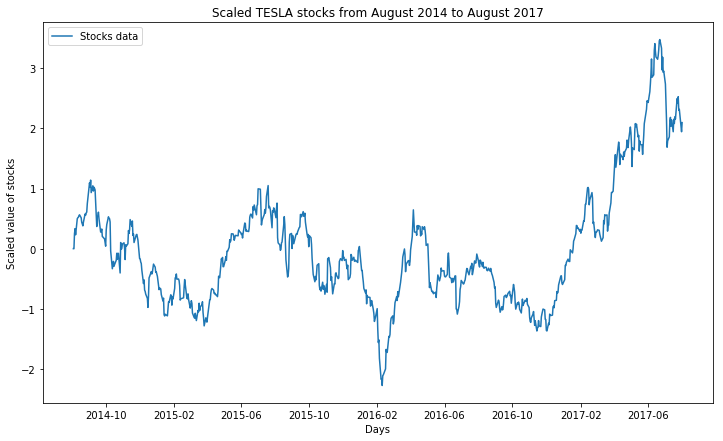

In [9]:
tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(tesla_stocks.Date, scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [9]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [10]:
X, y = window_data(scaled_dataset, 7)

#### Step 1.3 Creating Training and Testing sets

In [11]:
X_train  = np.array(X[:700])
y_train = np.array(y[:700])

X_test = np.array(X[700:])
y_test = np.array(y[700:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 1)
y_train size: (700, 1)
X_test size: (49, 7, 1)
y_test size: (49, 1)


### Let's create the Conv1D

In [12]:
epochs = 200
batch_size = 8
window_size = 7
number_of_classes = 1
learning_rate = 0.001

In [13]:
def output_layer(conv1d_output, out_size):
    
    ## global average pooling 1D
    x = tf.reduce_mean(conv1d_output, axis=[1])
    output = tf.layers.dense(inputs= x, units= out_size)
    return output

In [14]:
def opt_loss(logits, targets, learning_rate):

    loss = tf.reduce_mean(tf.pow(logits - targets, 2))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.minimize(loss)
    
    return loss, train_optimizer



### Tensorflow- 建立靜態圖 
​
**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行


In [15]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    ##defining placeholders##
    with tf.name_scope('input'):
        inputs = tf.placeholder(tf.float32, [None, window_size, 1], name='input_data')
        targets = tf.placeholder(tf.float32, [None, 1], name='targets')
        
    ##convolution layer##
    with tf.variable_scope("conv_layer1"):
        conv_layer1 = tf.layers.conv1d(inputs, 32, kernel_size=3, strides=1, activation=tf.nn.relu)
    with tf.variable_scope("conv_layer2"):
        conv_layer2 = tf.layers.conv1d(conv_layer1, 64, kernel_size=3, strides=1, activation=tf.nn.relu)

    ##Output layer##   
    with tf.variable_scope('output_layer'):
        logits = output_layer(conv_layer2, number_of_classes)
    ##loss and optimization##
    with tf.name_scope('loss_and_opt'):
        loss, opt = opt_loss(logits, targets, learning_rate)
    
    init = tf.global_variables_initializer()
    

### Time to train the network

In [16]:
sess.run(init)

In [17]:
for i in range(epochs):
    traind_scores = []
    batch_index = 0
    epoch_loss = []
    while(batch_index + batch_size) <= len(X_train):
        X_batch = X_train[batch_index:batch_index+batch_size]
        y_batch = y_train[batch_index:batch_index+batch_size]
        
        o, c, _ = sess.run([logits, loss, opt], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        batch_index += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.13274256885051727
Epoch 30/200  Current loss: 0.024725746363401413
Epoch 60/200  Current loss: 0.022065086290240288
Epoch 90/200  Current loss: 0.02069239318370819
Epoch 120/200  Current loss: 0.020080380141735077
Epoch 150/200  Current loss: 0.01915612630546093
Epoch 180/200  Current loss: 0.017849421128630638


In [18]:
#Training set預測結果
training_set_pred = np.array([])
for i in range(len(X_train)):
    o = sess.run(logits, feed_dict={inputs:[X_train[i]]})
    training_set_pred = np.append(training_set_pred, o)

In [19]:
#Testing set預測結果
testing_set_pred = np.array([])
for i in range(len(X_test)):
    o = sess.run(logits, feed_dict={inputs:[X_test[i]]})
    testing_set_pred = np.append(testing_set_pred, o)  

In [20]:
#把資料放到list裡面準備畫圖
#因為我們是用前七天預測第8天股價，故前七天設為None
training = [None]*window_size
for i in range(len(X_train)):
    training.append(training_set_pred[i])
testing = [None] * (window_size + len(X_train))
testing_loss = 0
for i in range(len(X_test)):
    testing.append(testing_set_pred[i])
    training.append(None)
    testing_loss += (testing_set_pred[i] - y_test[i])**2
print('testing_loss:', testing_loss / len(X_test))

testing_loss: [0.05901074]


### Plotting predictions from the network

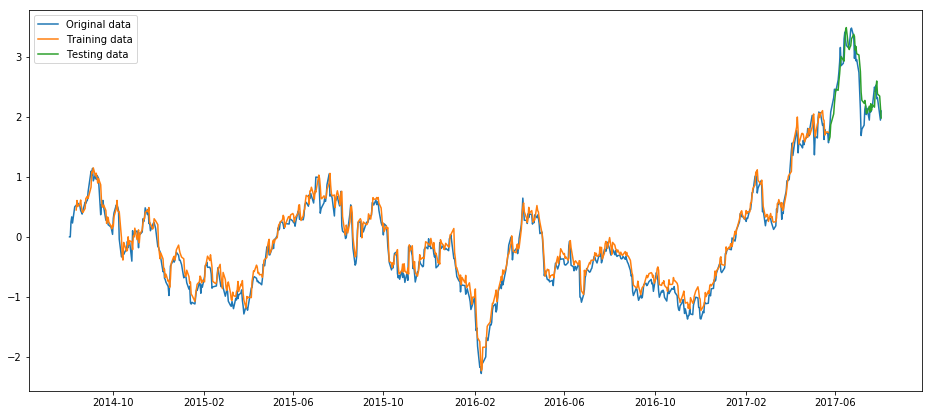

In [21]:
plt.figure(figsize=(16, 7))
plt.plot(tesla_stocks.Date, scaled_dataset, label='Original data')
plt.plot(tesla_stocks.Date, training, label='Training data')
plt.plot(tesla_stocks.Date, testing, label='Testing data')
plt.legend()
plt.show()

In [22]:
sess.close()